In [150]:
import sys
sys.path.append('../utils')
sys.path.append('..')

from utils.interpolate.markup_utils import Mask, load_markup, vis_markup, eternal_dataset_info, is_border_object
from utils.interpolate.refine_markup_by_yolo import mask_iou, mask_ioa, poly_mask_area

### Загрузка датасета и модели

In [151]:
CONFIG_PATH = '../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

In [152]:
# Load config
import json
import numpy as np
from pathlib import Path

### Подготавливаем данные

In [153]:
# Create temporary directory for predictions
pred_labels_dir = Path('runs/segment/predict/labels')
pred_images_dir = Path('runs/segment/predict')

In [154]:
from utils.integrate.integrate import shift_mask

In [155]:
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

In [156]:
def restrict(obj):
    obj = obj.copy()
    obj['points'] = np.clip(obj['points'], 0, config['imgsz'])
    return obj

In [157]:
from tqdm import tqdm
from statistics import mode

def get_groups(markups, speed, imgsz):
    groups = [
        [-1] * len(m) for m in markups
    ]
    group_id = 0
    for i, markup in enumerate(tqdm(markups)):
        for j, obj in enumerate(markup):
            if groups[i][j] != -1:
                continue
            obj = restrict(obj)
            matched_groups = []
            # Find if group already exists
            idx = i-1
            shift = 0
            while idx >= 0 and shift < 0.5 * imgsz:
                shift += speed[idx + 1]
                for k, other_obj in enumerate(markups[idx]):
                    obj2 = restrict(shift_mask(other_obj, -shift))
                    #canvas = np.zeros((imgsz, imgsz, 3), dtype=np.uint8)
                    # if group_id == 7:
                    #     vis_markup(canvas, [obj, obj2], Path(f'test/{idx}_{k}.png'))
                    if mask_ioa(obj, obj2) > IOU_THRESHOLD:
                        matched_groups.append(groups[idx][k])
                idx -= 1
            
            # if group_id == 7:
            #     print(matched_groups)
            
            if len(matched_groups) > 2:
                groups[i][j] = mode(matched_groups)
            else:
                groups[i][j] = group_id
                group_id += 1

            # Find next elements from this group
            idx = i+1
            shift = 0
            while idx < len(markups) and shift < 1.2 * imgsz:
                shift += speed[idx]
                for k, other_obj in enumerate(markups[idx]):
                    if groups[idx][k] != -1:
                        continue
                    if mask_ioa(obj, restrict(shift_mask(other_obj, shift))) > IOU_THRESHOLD:
                        groups[idx][k] = groups[i][j]
                idx += 1
    return groups

In [158]:
OLD_CLS_TO_NEW_INDICES = {'0': '0', '1': '0', '2': '1'}
def cls_transform(markup):
    result = []
    for m in markup.copy():
        m['cls'] = OLD_CLS_TO_NEW_INDICES[m['cls']]
        result.append(m)
    return result

In [159]:
from tqdm import tqdm
def get_matches(markups, other):
    is_matched = [
        [False] * len(m) for m in markups
    ]
    is_mask_matched = [
        [False] * len(m) for m in markups
    ]
    is_ioa_matched = [
        [False] * len(m) for m in markups
    ]
    is_mask_ioa_matched = [
        [False] * len(m) for m in markups
    ]
    for i, markup in enumerate(tqdm(markups)):
        for j, obj in enumerate(markup):
            obj = restrict(obj)
            for other_obj in other[i]:
                other_obj = restrict(other_obj)
                # Match mask
                if mask_iou(obj, other_obj) > IOU_THRESHOLD:
                    is_mask_matched[i][j] = True
                    # Match class
                    if obj['cls'] == other_obj['cls']:
                        is_matched[i][j] = True
                if mask_ioa(obj, other_obj) > IOU_THRESHOLD:
                    is_mask_ioa_matched[i][j] = True
                    # Match class
                    if obj['cls'] == other_obj['cls']:
                        is_ioa_matched[i][j] = True
                    
    return is_matched, is_mask_matched, is_ioa_matched, is_mask_ioa_matched

In [160]:
def idx_to_groups(group_idx, matching_info, markup, img_paths):
    is_matched, is_mask_matched, is_ioa_matched, is_mask_ioa_matched = matching_info
    groups = [[] for i in range(max(y for x in group_idx for y in x) + 1)]
    for i, group in enumerate(group_idx):
        for j, g in enumerate(group):
            img_path = img_paths[i]
            groups[g].append({
                "img": img_path, 
                "obj": markup[i][j], 
                "is_border": is_border_object(Mask(markup[i][j]), (config['imgsz'], config['imgsz'])), 
                "is_matched": is_matched[i][j],
                "is_mask_matched": is_mask_matched[i][j],
                "is_ioa_matched": is_ioa_matched[i][j],
                "is_mask_ioa_matched": is_mask_ioa_matched[i][j]
            })
    return groups

### Предсказание с лучшим по F1 confidence

In [161]:
MODEL_VERSION = 'default'

In [162]:
import shutil

def find_best_conf(model, config):
    # Run validation to get best confidence threshold
    val_results = model.val(data=config['data'], split=SPLIT, device='cuda:1')

    best_f1_idx = np.argmax(val_results.seg.curves_results[1][1].mean(axis=0))
    best_f1 = val_results.seg.curves_results[1][1][..., best_f1_idx].mean()
    best_conf = val_results.seg.curves_results[1][0][best_f1_idx]
    print(f"Best F1: {best_f1:.4f} at confidence {best_conf:.4f}")
    return best_conf


def get_gt_and_predicted_groups(model, config, dataset_path, conf):

    # Load labels
    dataset_path = Path(dataset_path)
    dataset_info = eternal_dataset_info(dataset_path)
    gt_labels_dir = Path(dataset_path) / 'gt_interp'
    
    shutil.rmtree('runs/segment', ignore_errors=True)
    # Run YOLO validation to get the best confidence score

    # Run prediction with best confidence
    for pred in model.predict(
        source=str(dataset_path / 'imgs'),
        conf=conf,
        save_txt=True,
        device='cuda:1',
        save=True,
        stream=True
    ):
        pass
    
    gt = []
    pred = []
    speed = []
    gt_paths = sorted(list(gt_labels_dir.glob("*.txt")))
    for gt_path in gt_paths:
        pred_path = pred_labels_dir / gt_path.name
        if not pred_path.exists():
            pred_path.touch()
        gt.append(cls_transform(load_markup(gt_path, config['imgsz'])))
        pred.append(load_markup(pred_path, config['imgsz']))
        speed.append(dataset_info['speed'][str(dataset_path / 'imgs' / (gt_path.stem + '.jpg'))])

    gt_img_paths = [p.parent.parent / 'imgs' / f'{p.stem}.jpg' for p in gt_paths]
    pred_img_paths = [pred_images_dir / f'{p.stem}.jpg' for p in gt_paths]

    gt_group_idx = get_groups(gt, speed, config['imgsz'])
    gt_matching_info = get_matches(gt, pred)
    gt_groups = idx_to_groups(gt_group_idx, gt_matching_info, gt, gt_img_paths)
    
    pred_group_idx = get_groups(pred, speed, config['imgsz'])
    pred_matching_info = get_matches(pred, gt)
    pred_groups = idx_to_groups(pred_group_idx, pred_matching_info, pred, pred_img_paths)
    
    return gt_groups, pred_groups

In [163]:
# gt_groups_per_dataset = []
# pred_groups_per_dataset = []

# from ultralytics import YOLO
# model = YOLO(config['models'][MODEL_VERSION])
# import torch

# conf = find_best_conf(model, config)

# for dataset_path in config['interpolated']['datasets']:
#     gt_groups, pred_groups = get_gt_and_predicted_groups(model, config, dataset_path, conf)
#     gt_groups_per_dataset.append(gt_groups)
#     pred_groups_per_dataset.append(pred_groups)

In [60]:
for group in pred_groups[10:30]:
    matches = [instance['is_matched'] for instance in group]
    
    print([bool(f) for f in matches], np.array(matches).mean())

[False, True, True, True, True, True, True, True] 0.875
[True, True, True, True, True, True, True, True, True, True, True, True, True, True] 1.0
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True] 1.0
[False, False, False, False] 0.0
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True] 1.0
[False] 0.0
[False, False] 0.0
[True] 1.0
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False] 0.0
[False, False, False] 0.0
[False, False, False, False, False, False, False] 0.0
[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True] 0.9333333333333333
[False] 0.0
[True, True, True, True, True, True, True, True, True] 1.0
[False] 0.0
[False, False, False, False, False, False] 0.0
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

In [ ]:
# import pickle
# with open('gt_groups_test_extended.pkl', 'wb') as f:
#     pickle.dump(gt_groups, f)
# with open('pred_groups_test_extended.pkl', 'wb') as f:
#     pickle.dump(pred_groups, f)
# with open('gt_groups_per_dataset_test_extended.pkl', 'wb') as f:
#     pickle.dump(gt_groups_per_dataset, f)
# with open('pred_groups_per_dataset_test_extended.pkl', 'wb') as f:
#     pickle.dump(pred_groups_per_dataset, f)

NameError: name 'gt_groups' is not defined

In [186]:
import pickle
# with open('gt_groups.pkl', 'rb') as f:
#     gt_groups = pickle.load(f)
# with open('pred_groups.pkl', 'rb') as f:
#     pred_groups = pickle.load(f)
with open('gt_groups_per_dataset_test_extended.pkl', 'rb') as f:
    gt_groups_per_dataset = pickle.load(f)
with open('pred_groups_per_dataset_test_extended.pkl', 'rb') as f:
    pred_groups_per_dataset = pickle.load(f)

gt_groups = []
pred_groups = []
for gt_group in gt_groups_per_dataset:
    gt_groups += gt_group
for pred_group in pred_groups_per_dataset:
    pred_groups += pred_group

##### Отфильтурем объекты по тем, что встречались в неинтерполированном тестовом датасете

In [ ]:
import random
interp_test_imgs_path = Path(config['interpolated']['test']).parent / 'test' / 'images'
interpolated_test_names = set(p.name for p in interp_test_imgs_path.iterdir() if not p.name.startswith('tula_sep_0002_2024_07_22_17') or random.random() < 0.95)

In [188]:
gt_groups = [[m for m in g if m['img'].name in interpolated_test_names] for g in gt_groups]
gt_groups = [g for g in gt_groups if len(g) > 0]

In [189]:
pred_groups = [[m for m in g if m['img'].name in interpolated_test_names] for g in pred_groups]
pred_groups = [g for g in pred_groups if len(g) > 0]

In [190]:
cnt = {}
for g in pred_groups:
    for m in g:
        dir = m['img'].name[:len('tula_sep_0002_2024_07_22_18')]
        if dir not in cnt:
            cnt[dir] = 0
        cnt[dir] += 1
for k, v in cnt.items():
    print(k, '\t', v)

tula_sep_0002_2024_07_22_18 	 15490
tula_sep_0002_2024_07_16_14 	 9274
tula_sep_0002_2024_07_16_15 	 8789
tula_sep_0002_2024_07_16_16 	 5131
tula_sep_0002_2024_07_22_16 	 1209
tula_sep_0002_2024_07_22_17 	 30060


In [191]:
cnt = {}
for g in gt_groups:
    for m in g:
        dir = m['img'].name[:len('tula_sep_0002_2024_07_22_18')]
        if dir not in cnt:
            cnt[dir] = 0
        cnt[dir] += 1
for k, v in cnt.items():
    print(k, '\t', v)

tula_sep_0002_2024_07_22_18 	 17507
tula_sep_0002_2024_07_16_14 	 11312
tula_sep_0002_2024_07_16_15 	 10487
tula_sep_0002_2024_07_16_16 	 4861
tula_sep_0002_2024_07_22_16 	 1289
tula_sep_0002_2024_07_22_17 	 27743


##### Добавим дополнительные свойства

In [170]:
# Update border objects and calculate area
for g in gt_groups:
    for instance in g:
        instance['is_border'] = is_border_object(Mask(instance['obj']), (config['imgsz'], config['imgsz']))
        instance['area'] = poly_mask_area(instance['obj'])
for g in pred_groups:
    for instance in g:
        instance['is_border'] = is_border_object(Mask(instance['obj']), (config['imgsz'], config['imgsz']))
        instance['area'] = poly_mask_area(instance['obj'])

In [171]:
# Calculate area share based on the group's max area
for groupset in [gt_groups, pred_groups]:
    for g in groupset:
        max_area = max([instance['area'] for instance in g])
        for instance in g:
            instance['area_share'] = instance['area'] / max_area

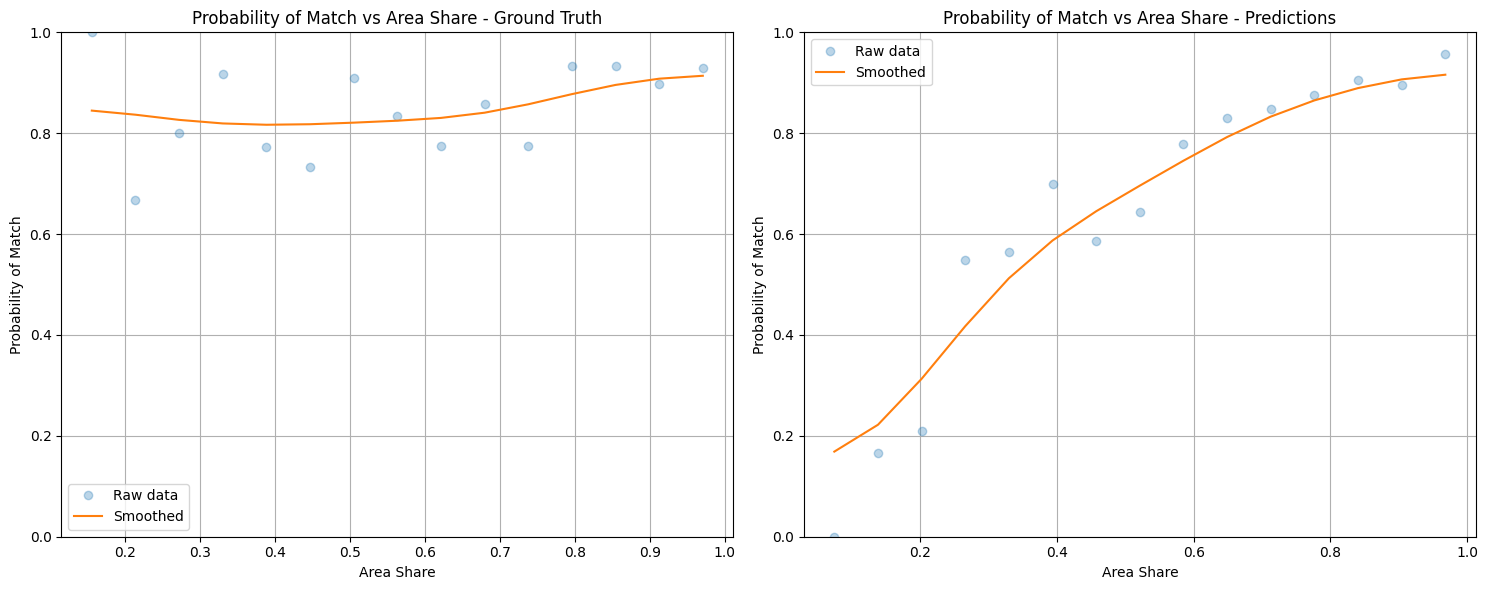

In [172]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_match_probability(groupset, title):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])

    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)

    # Create bins and calculate probabilities
    bins = np.linspace(area_shares.min(), area_shares.max(), 16)
    bin_indices = np.digitize(area_shares, bins) - 1
    probabilities = []
    bin_centers = []

    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            prob = np.mean(is_matched[mask])
            probabilities.append(prob)
            bin_centers.append((bins[i] + bins[i+1]) / 2)

    # Apply Gaussian smoothing
    probabilities = np.array(probabilities)
    smoothed_probabilities = gaussian_filter(probabilities, sigma=2)

    # Plot probability distribution
    plt.plot(bin_centers, probabilities, 'o', alpha=0.3, label='Raw data')
    plt.plot(bin_centers, smoothed_probabilities, '-', label='Smoothed')
    plt.ylim(0, 1)
    plt.xlabel('Area Share')
    plt.ylabel('Probability of Match')
    plt.title(f'Probability of Match vs Area Share - {title}')
    plt.grid(True)
    plt.legend()

# Create subplots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_match_probability(gt_groups, 'Ground Truth')
plt.subplot(1, 2, 2)
plot_match_probability(pred_groups, 'Predictions')
plt.tight_layout()
plt.show()


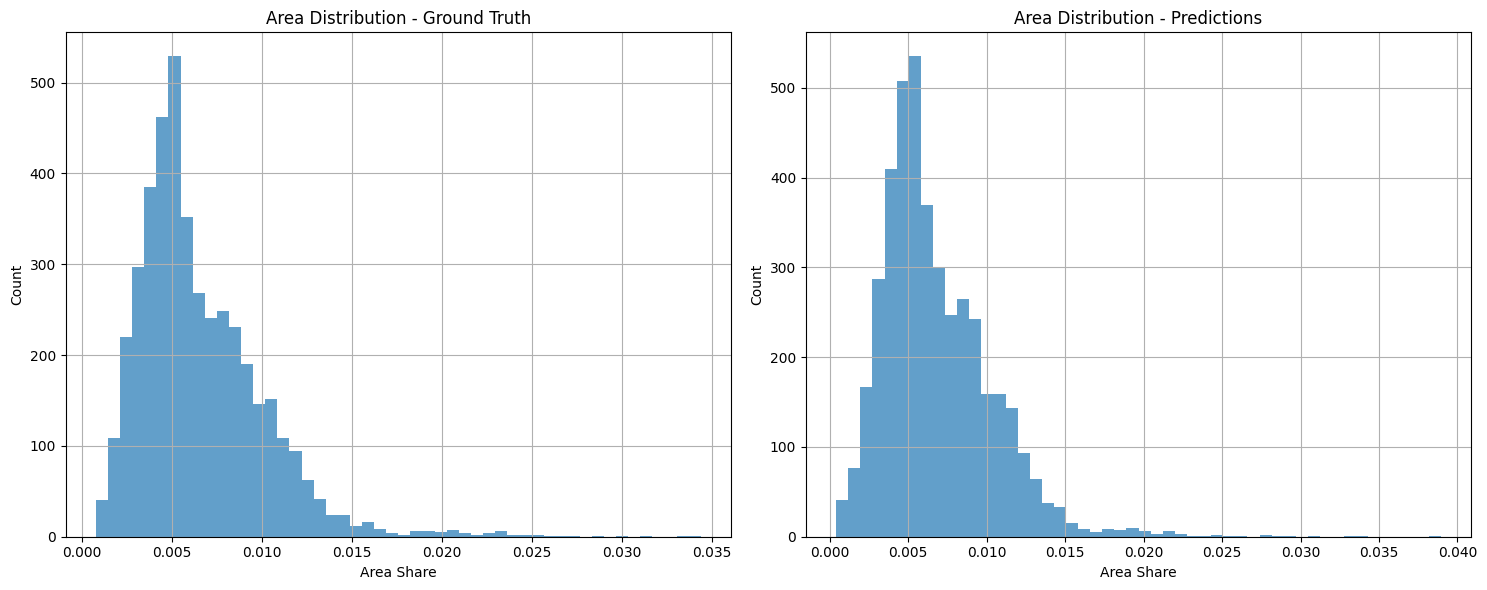

In [173]:
# Plot area distribution histograms
plt.figure(figsize=(15, 6))

# Ground Truth histogram
plt.subplot(1, 2, 1)
gt_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
            for group in gt_groups 
            for instance in group]
plt.hist(gt_areas, bins=50, alpha=0.7)
plt.xlabel('Area Share')
plt.ylabel('Count')
plt.title('Area Distribution - Ground Truth')
plt.grid(True)

# Predictions histogram
plt.subplot(1, 2, 2)
pred_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
              for group in pred_groups 
              for instance in group]
plt.hist(pred_areas, bins=50, alpha=0.7)
plt.xlabel('Area Share')
plt.ylabel('Count')
plt.title('Area Distribution - Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()


In [174]:
from scipy import stats

def get_correlation_data(groupset):
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    return np.array(area_shares), np.array(is_matched)

# Get data for GT and Pred
gt_areas, gt_matched = get_correlation_data(gt_groups)
pred_areas, pred_matched = get_correlation_data(pred_groups)

# Combine data for total
total_areas = np.concatenate([gt_areas, pred_areas])
total_matched = np.concatenate([gt_matched, pred_matched])

# Calculate correlations and p-values
gt_corr, gt_pval = stats.pearsonr(gt_areas, gt_matched)
pred_corr, pred_pval = stats.pearsonr(pred_areas, pred_matched)
total_corr, total_pval = stats.pearsonr(total_areas, total_matched)

# Print results in a formatted table
print(f"{'Dataset':<10} {'Correlation':>12} {'P-value':>12}")
print("-" * 34)
print(f"{'GT':<10} {gt_corr:>12.4f} {gt_pval:>12.4e}")
print(f"{'Pred':<10} {pred_corr:>12.4f} {pred_pval:>12.4e}")
print(f"{'Total':<10} {total_corr:>12.4f} {total_pval:>12.4e}")

Dataset     Correlation      P-value
----------------------------------
GT               0.0079   6.0153e-01
Pred             0.2472   7.3162e-60
Total            0.1360   1.4888e-36


In [175]:
def get_match_probability(groupset, a, b):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    
    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)
    
    # Find objects within the specified range
    mask = (area_shares >= a) & (area_shares <= b)
    
    # Calculate probability if there are objects in the range
    if np.sum(mask) > 0:
        probability = np.mean(is_matched[mask])
        return probability
    else:
        return None

In [176]:
get_match_probability(gt_groups, 0.8, 1.0)

np.float64(0.852926709296606)

#### Все объекты

In [177]:
print("Per-mask precision:", (bpm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g]).mean()))
print("Per-obj precision:", (bpo_p := np.array([max(float(m['is_matched']) for m in g) for g in pred_groups]).mean()))

Per-mask precision: 0.8721590909090909
Per-obj precision: 0.8951191167925625


In [178]:
print("Per-mask recall:", (bpm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g]).mean()))
print("Per-obj recall:", (bpo_r := np.array([max(float(m['is_matched']) for m in g) for g in gt_groups]).mean()))

Per-mask recall: 0.8512262841277186
Per-obj recall: 0.8542354235423543


In [179]:
print("Per-mask F1:", bpm_p * bpm_r / (bpm_p + bpm_r) * 2)
print("Per-obj F1:", bpo_p * bpo_r / (bpo_p + bpo_r) * 2)

Per-mask F1: 0.8615655591331657
Per-obj F1: 0.8741995292821096


#### Без краевых объектов

In [124]:
print("Per-mask precision:", (pm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g if not m['is_border']]).mean()))
print("Per-obj precision:", (po_p := np.array([max(float(m['is_matched']) for m in g if not m['is_border']) for g in pred_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask precision: 0.7503086033239709
Per-obj precision: 0.7802755620014503


In [125]:
print("Per-mask recall:", (pm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g if not m['is_border']]).mean()))
print("Per-obj recall:", (po_r := np.array([max([float(m['is_matched']) for m in g if not m['is_border']] + [0]) for g in gt_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask recall: 0.7748468627559185
Per-obj recall: 0.9225695440206482


In [126]:
print("Per-mask F1:", pm_p * pm_r / (pm_p + pm_r) * 2)
print("Per-obj F1:", po_p * po_r / (po_p + po_r) * 2)

Per-mask F1: 0.7623803347453638
Per-obj F1: 0.8454773330825676


#### Доля ошибок классификации


In [140]:
print("GT per-mask ratio:", np.array([float(m['is_mask_matched']) for g in gt_groups for m in g if not m['is_matched']]).mean())
print("GT per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in gt_groups if max(float(m['is_matched']) for m in g) == False]).mean())

GT per-mask ratio: 0.019897333393903604
GT per-obj ratio: 0.16818181818181818


In [141]:
print("Pred per-mask ratio:", np.array([float(m['is_mask_matched']) for g in pred_groups for m in g if not m['is_matched']]).mean())
print("Pred per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in pred_groups if max(float(m['is_matched']) for m in g) == False]).mean())

Pred per-mask ratio: 0.0259643124265413
Pred per-obj ratio: 0.02997694081475788


### Гипотеза о зависимости обрезанности и качества распознавания

In [142]:
gt_is_matched = []
gt_is_border = []
pred_is_matched = []
pred_is_border = []

for group in gt_groups:
    for obj in group:
        gt_is_matched.append(obj['is_matched'])
        gt_is_border.append(obj['is_border'])
        
for group in pred_groups:
    for obj in group:
        pred_is_matched.append(obj['is_matched'])
        pred_is_border.append(obj['is_border'])

is_matched = {"Pred": pred_is_matched, "GT": gt_is_matched, 'Total': pred_is_matched + gt_is_matched}
is_border = {"Pred": pred_is_border, "GT": gt_is_border, 'Total': pred_is_border + gt_is_border}

In [143]:
from scipy.stats import spearmanr

print("| Sample | Spearman correlation | p-value               |")
print("|--------|----------------------|-----------------------|")
for sample in ['GT', 'Pred', 'Total']:
    corr, p_value = spearmanr(is_border[sample], is_matched[sample])
    print(f"| {sample:>6} | {corr:>20.6f} | {p_value:>21} |")

| Sample | Spearman correlation | p-value               |
|--------|----------------------|-----------------------|
|     GT |            -0.279979 |                   0.0 |
|   Pred |            -0.080580 | 4.2006140015077443e-101 |
|  Total |            -0.190466 |                   0.0 |


### Количество объектов, предсказанных только по краевым объектам

In [144]:
def get_border_only_matched(groups):
    border_only_matched = []
    border_only_matched_ids = []
    for i, group in enumerate(groups):
        border_matched = False
        non_border_matched = False
        non_border_found = False
        for obj in group:
            if obj['is_matched']:
                if obj['is_border']:
                    border_matched = True
                else:
                    non_border_matched = True
            if not obj['is_border']:
                non_border_found = True
        if border_matched and not non_border_matched and non_border_found:
            border_only_matched.append(group)
            border_only_matched_ids.append(i)
    return border_only_matched, border_only_matched_ids

In [145]:
gt_border_only, gt_border_ids = get_border_only_matched(gt_groups)
pred_border_only, pred_border_ids = get_border_only_matched(pred_groups)

In [146]:
print("GT:", len(gt_border_only), "elements", "out of", len(gt_groups), f"({len(gt_border_only) / len(gt_groups) * 100:.2f}%)")
print("Pred:", len(pred_border_only), "elements", "out of", len(pred_groups), f"({len(pred_border_only) / len(pred_groups) * 100:.2f}%)")

GT: 66 elements out of 3641 (1.81%)
Pred: 63 elements out of 4740 (1.33%)


In [147]:
idx = 60
print([p['is_border'] for p in gt_border_only[idx]])
print([p['is_matched'] for p in gt_border_only[idx]])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True]


In [148]:
iidx = 0
gidx = gt_border_ids[idx]

False False /alpha/projects/wastie/eternal-storage/dataset/tula_sep_0002_2024_07_22_17_30/imgs/tula_sep_0002_2024_07_22_17_48_54_200.jpg


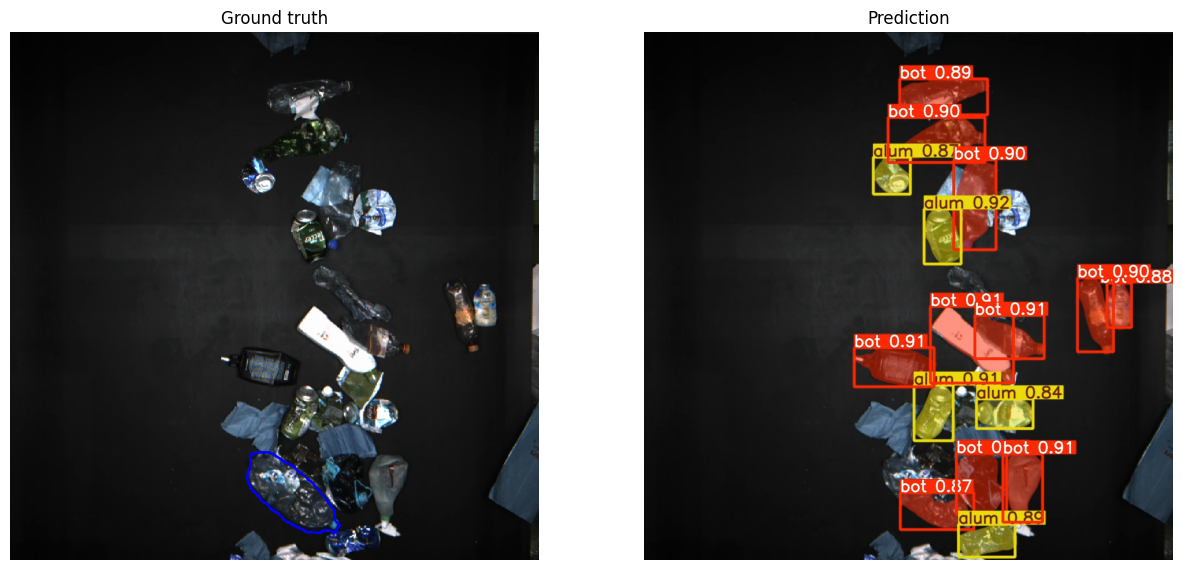

In [149]:

%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from utils.interpolate.markup_utils import vis_markup

for instance in gt_groups[gidx][iidx:iidx+1]:
    print(instance['is_matched'], instance['is_border'], instance['img'])
    img = cv2.imread(instance['img'])
    img = vis_markup(img, [instance['obj']])
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].set_title('Ground truth')
    axs[0].axis('off')
    axs[0].imshow(img)
    
    pred_img_path = pred_images_dir / f'{instance["img"].stem}.jpg'
    img = cv2.imread(pred_img_path)
    axs[1].set_title('Prediction')
    axs[1].axis('off')
    axs[1].imshow(img)
iidx += 1
plt.show()

In [218]:
iidx = 0
idx += 1
gidx = gt_border_ids[idx]